# Notebook F — Build *iterative-loop* training pairs: (high‑freq residual → high‑freq error)

You said you **do not** want an ML model that maps `u_ω′ → u_ω`.  
Instead, you want **one ML operator inside the iterative loop**.

This notebook generates supervised training pairs for a learned corrector:

\[
\mathcal{C}_\theta:\ (r_\omega^{(k)},\ c,\ \omega) \mapsto e_\omega^{(k)}\approx u_\omega^* - u_\omega^{(k)}
\]

where:

- `u_ω*` is the **direct** high‑frequency solution (ground truth)
- `u_ω^{(k)}` is the current iterate (starts from zero)
- `r_ω^{(k)} = f - A(ω) u_ω^{(k)}` is the **high‑frequency residual**
- `e_ω^{(k)} = u_ω* - u_ω^{(k)}` is the **true high‑frequency error** (training target)

## Physics step used to generate iterates (baseline loop)
We generate `u_ω^{(k)}` with a *two-frequency* (ω′=ω/2) preconditioned update using **identity transfer**:

1. `r = f - A_hi u`
2. `e_lo = A_lo^{-1} r`  (solve at ω′)
3. `u ← u + e_lo`        (identity up-transfer)

This produces a realistic sequence of residual/error pairs without learning any transfer yet.

---

## What gets saved per training pair
For each **sample_id** and **iteration k**, we save an `.npz` containing (physical domain only):

- `c` (float32)
- `f_re`, `f_im`
- `r_re`, `r_im`  (input)
- `e_re`, `e_im`  (target = true error)
- metadata JSON: omega, omega_low, iter, rhs metadata, norms, etc.

We also create an `index.csv` (written with Python `csv`, no pandas).

In [1]:
# ---- Imports: use functions defined in src/ ----
import json
import csv
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from core.config import HelmholtzConfig, PMLConfig
from core.cases import make_default_cases
from core.medium import build_medium
from core.rhs import RHSConfig, assemble_rhs
from core.resolution import grid_from_ppw_with_pml_extension
from core.grid import embed_in_extended, extract_physical

from operators.assemble import assemble_helmholtz_matrix
from operators.solve import solve_linear_system, compute_residual, solve_helmholtz

np.set_printoptions(precision=3, suppress=True)

In [2]:
# =========================
# Configuration (edit here)
# =========================

OUT_ROOT = Path("data/iterloop_residual_to_error_dataset")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# Physical domain size
LX, LY = 1.0, 1.0

# Frequencies (requested: lowest ω′ = 32, ω = 2 ω′)
OMEGA_LOW_LIST = [32, 40, 48, 56, 64]   # ω′ values
RATIO = 2.0                              # ω = 2 ω′

# Grid rule (physical grid must be >= 501×501)
PPW = 10.0
N_MIN_PHYS = 501

# Tuned PML settings from your sweep
NPML = 40
ETA = 7.0
PML_POWER = 3.0

# RHS: random 1–5 delta-like sources (narrow Gaussians)
RHS_CFG = RHSConfig(
    mode="random_gaussians",
    k_min=1,
    k_max=5,
    amp_dist="uniform",
    amp_scale=1.0,
    complex_amps=True,
    width_min_cells=1.5,
    width_max_cells=2.5,
    avoid_pml=True,
    pml_margin_cells=4,
    normalize="l2",
    target_norm=1.0,
    base_seed=0,
    include_omega_in_seed=False,  # same RHS for (ω′, ω)
    zero_boundary=True,
)

# Iterations per sample (how many (r->e) pairs to extract)
N_ITER = 3

# Dataset sizes (small first; scale later)
N_TRAIN = 50
N_VAL   = 5
N_TEST  = 5

# Medium
CASES = make_default_cases()
CASE_NAME = "const"

# Reproducibility (omega selection)
np.random.seed(0)

## Core routine: one sample → multiple (residual, error) pairs

We keep new logic minimal and orchestrate existing `src/` functions:

- Build **one shared extended grid** using ω (high).
- Build medium `c` + RHS `f` on the physical grid.
- Embed into extended arrays.
- Assemble `A_hi` and `A_lo` (sparse).
- Compute **direct ground truth** `u_hi*` via `solve_helmholtz`.
- Run `N_ITER` refinement steps starting from `u=0` to get iterates.
- At each k, compute:
  - `r_k = f - A_hi u_k`  (input)
  - `e_k = u_hi* - u_k`   (target)

All saved arrays are **physical-domain slices** (easy for ML).

In [3]:
def build_one_sample_pairs(*, omega_low: float, sample_id: int, case_name: str = CASE_NAME, n_iter: int = N_ITER):
    omega_low = float(omega_low)
    omega_high = float(RATIO) * omega_low
    case = CASES[case_name]

    # 1) Shared extended grid built from omega_high
    ext = grid_from_ppw_with_pml_extension(
        omega=omega_high,
        ppw=PPW,
        lx=LX, ly=LY,
        npml=NPML,
        c_min=1.0,
        n_min_phys=N_MIN_PHYS,
        make_odd_phys=True,
        x_min_phys=0.0,
        y_min_phys=0.0,
    )
    gphys, gext = ext.grid_phys, ext.grid_ext
    core = ext.core_slices

    # 2) Physical medium and RHS
    Xp, Yp = gphys.mesh()
    cfg_phys = HelmholtzConfig(omega=omega_low, grid=gphys, pml=None)
    c_phys = build_medium(cfg_phys, case, Xp, Yp).astype(float)

    f_vec, rhs_meta = assemble_rhs(cfg_phys, case, Xp, Yp, rhs_cfg=RHS_CFG, sample_id=int(sample_id), return_meta=True)
    f_phys = np.asarray(f_vec, dtype=np.complex128).reshape(gphys.nx, gphys.ny)

    # 3) Embed to extended
    c_ref = float(np.min(c_phys))
    c_ext = embed_in_extended(c_phys, (gext.nx, gext.ny), core, fill_value=c_ref, dtype=float)
    f_ext_2d = embed_in_extended(f_phys, (gext.nx, gext.ny), core, fill_value=0.0, dtype=np.complex128)
    f_ext = np.asarray(f_ext_2d).reshape(-1)

    # 4) Build configs on extended grid
    def mk_cfg(omega: float) -> HelmholtzConfig:
        return HelmholtzConfig(
            omega=float(omega),
            grid=gext,
            pml=PMLConfig(thickness=int(NPML), strength=float(ETA * omega), power=float(PML_POWER)),
        )

    cfg_lo = mk_cfg(omega_low)
    cfg_hi = mk_cfg(omega_high)

    # 5) Assemble operators
    A_lo = assemble_helmholtz_matrix(cfg_lo, c_ext)
    A_hi = assemble_helmholtz_matrix(cfg_hi, c_ext)

    # 6) Ground truth high-frequency solution u_hi*
    sol_hi = solve_helmholtz(cfg_hi, c=c_ext, f=f_ext, return_matrix=False, return_residual=True)
    u_hi_star_ext = sol_hi["u"]                   # vector on extended
    U_hi_star_phys = extract_physical(sol_hi["U"], core)

    # 7) Iterative loop starting from u=0 (extended vector)
    u = np.zeros_like(f_ext, dtype=np.complex128)

    pairs = []
    f_norm = float(np.linalg.norm(f_ext) + 1e-30)

    for k in range(int(n_iter)):
        # residual at high frequency
        r_ext = compute_residual(A_hi, u, f_ext)

        # true error (target) on extended
        e_true_ext = u_hi_star_ext - u

        # store physical-domain slices for ML
        r_phys = extract_physical(r_ext.reshape(gext.nx, gext.ny), core)
        e_phys = extract_physical(e_true_ext.reshape(gext.nx, gext.ny), core)

        pairs.append({
            "k": k,
            "c": c_phys,
            "f": f_phys,
            "r": r_phys,
            "e": e_phys,
            "omega_low": omega_low,
            "omega_high": omega_high,
            "rhs_meta": rhs_meta,
            "rel_res": float(np.linalg.norm(r_ext) / f_norm),
            "u_norm": float(np.linalg.norm(u)),
        })

        # physics update using low-frequency solve as preconditioner (identity transfer)
        e_lo_ext = solve_linear_system(A_lo, r_ext)
        u = u + e_lo_ext

    meta_common = {
        "case": case_name,
        "sample_id": int(sample_id),
        "omega_low": omega_low,
        "omega_high": omega_high,
        "grid_phys": {"nx": int(gphys.nx), "ny": int(gphys.ny), "lx": float(gphys.lx), "ly": float(gphys.ly), "hx": float(gphys.hx), "hy": float(gphys.hy)},
        "grid_ext": {"nx": int(gext.nx), "ny": int(gext.ny), "lx": float(gext.lx), "ly": float(gext.ly), "hx": float(gext.hx), "hy": float(gext.hy)},
        "pml": {"npml": int(NPML), "eta": float(ETA), "power": float(PML_POWER)},
        "rhs_meta": rhs_meta,
        "direct_solve_norms": sol_hi.get("norms", {}),
    }

    return pairs, meta_common

## Visualization helper (intuition)

We visualize, per iteration `k`:

- `|r_k|` (input the ML model will see)
- `|e_k|` (target error the ML model should predict)
- (optional) `Re(r_k)` and `Re(e_k)`

Also plot a simple convergence trace: `rel_res(k)`.

In [6]:
import matplotlib.pyplot as plt

def plot_iter_pairs(pairs, *, show_real=False):
    rel_res = [p["rel_res"] for p in pairs]
    plt.figure(figsize=(4.5, 3.0))
    plt.plot(range(len(rel_res)), rel_res, marker="o")
    plt.yscale("log")
    plt.title("High-frequency relative residual per iter")
    plt.xlabel("k")
    plt.ylabel("||r_k||2 / ||f||2")
    plt.grid(True, which="both", ls=":")
    plt.show()

    for p in pairs:
        r = p["r"]
        e = p["e"]
        k = p["k"]

        # --- magnitude plots with colorbar in a separate right column ---
        fig = plt.figure(figsize=(9.6, 3.3))
        gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.25)
        ax0 = fig.add_subplot(gs[0, 0])
        ax1 = fig.add_subplot(gs[0, 1])
        cax = fig.add_subplot(gs[0, 2])

        im0 = ax0.imshow(np.abs(r), origin="lower")
        ax0.set_title(f"|r_{k}|")
        im1 = ax1.imshow(np.abs(e), origin="lower")
        ax1.set_title(f"|e_{k}| (true error)")

        for a in (ax0, ax1):
            a.set_xticks([])
            a.set_yticks([])

        fig.colorbar(im1, cax=cax)
        plt.show()

        if show_real:
            # --- real-part plots with separate colorbar axis ---
            fig = plt.figure(figsize=(9.6, 3.3))
            gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.25)
            ax0 = fig.add_subplot(gs[0, 0])
            ax1 = fig.add_subplot(gs[0, 1])
            cax = fig.add_subplot(gs[0, 2])

            im0 = ax0.imshow(np.real(r), origin="lower")
            ax0.set_title(f"Re(r_{k})")
            im1 = ax1.imshow(np.real(e), origin="lower")
            ax1.set_title(f"Re(e_{k})")

            for a in (ax0, ax1):
                a.set_xticks([])
                a.set_yticks([])

            fig.colorbar(im1, cax=cax)
            plt.show()


## Smoke test: build one sample and inspect the pairs

This should:
- run a direct high-frequency solve
- run `N_ITER` refinement steps from `u=0`
- plot residuals and true errors per iteration

Meta: {'case': 'const', 'sample_id': 0, 'omega_low': 32.0, 'omega_high': 64.0, 'pml': {'npml': 40, 'eta': 7.0, 'power': 3.0}}
Per-iter rel_res: [1.0, 3.5912148032302764, 112.01040215843291]


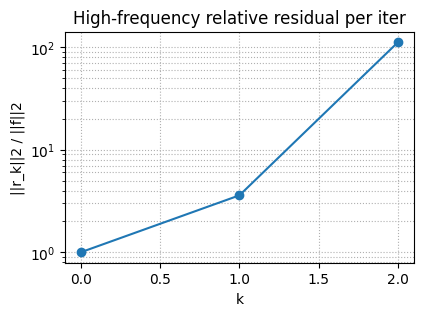

C:\Users\31624\AppData\Local\Temp\ipykernel_25800\3980986507.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


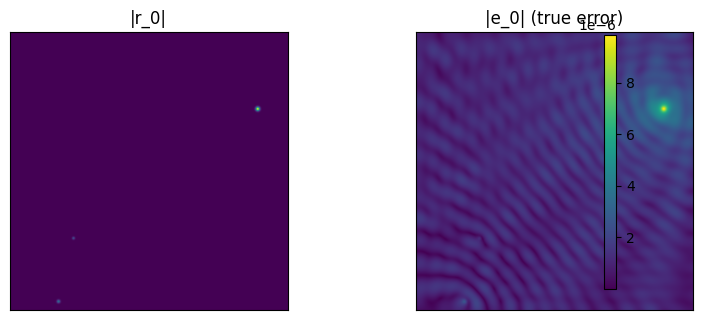

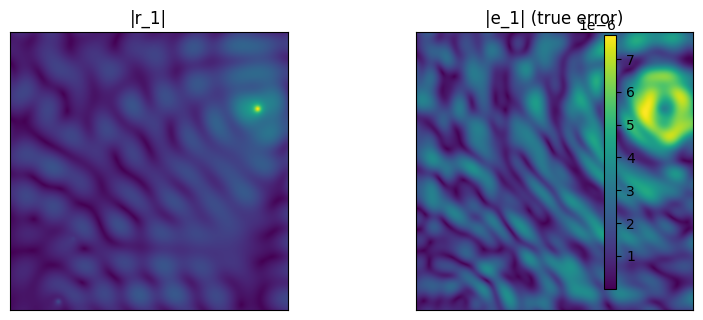

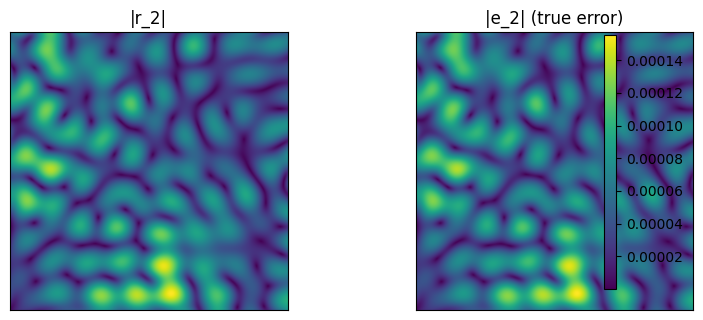

In [5]:
omega_low = OMEGA_LOW_LIST[0]
pairs, meta = build_one_sample_pairs(omega_low=omega_low, sample_id=0, n_iter=N_ITER)

print("Meta:", {k: meta[k] for k in ["case","sample_id","omega_low","omega_high","pml"]})
print("Per-iter rel_res:", [p["rel_res"] for p in pairs])

plot_iter_pairs(pairs, show_real=False)

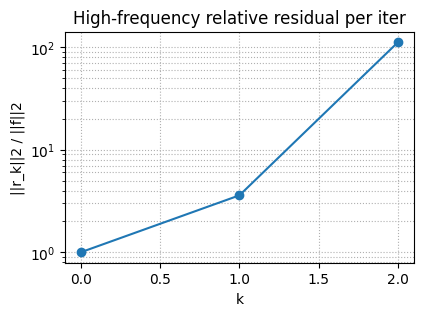

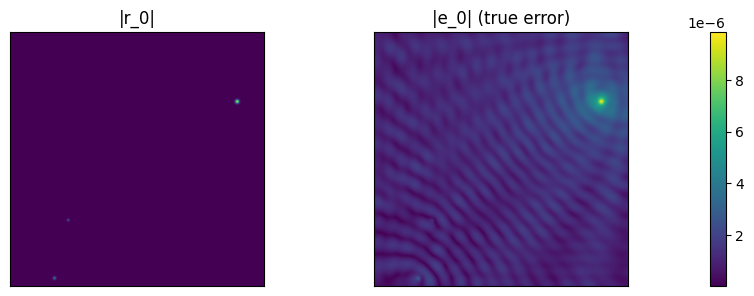

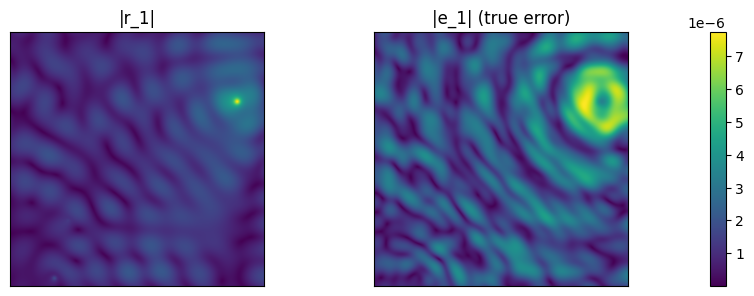

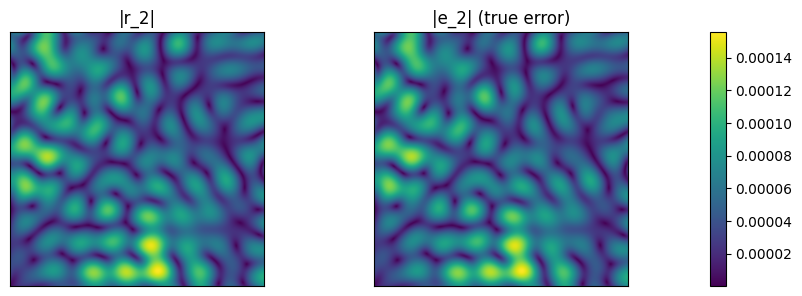

In [7]:
plot_iter_pairs(pairs, show_real=False)

## Saving `.npz` pairs (no pandas)

We save one `.npz` per (sample_id, iter k).  
This keeps loading trivial and avoids huge monolithic files early on.

Filename pattern:
`{case}_sid{sample_id:06d}_k{k}_w{omega_low}_w{omega_high}.npz`

In [8]:
import datetime

def save_pair_npz(folder: Path, *, sample_id: int, k: int, case: str, omega_low: float, omega_high: float,
                  c: np.ndarray, f: np.ndarray, r: np.ndarray, e: np.ndarray, meta_common: dict, meta_iter: dict):
    folder.mkdir(parents=True, exist_ok=True)

    meta = dict(meta_common)
    meta.update(meta_iter)
    meta["created_utc"] = datetime.datetime.utcnow().isoformat() + "Z"

    c = c.astype(np.float32)
    f = f.astype(np.complex64)
    r = r.astype(np.complex64)
    e = e.astype(np.complex64)

    fname = f"{case}_sid{sample_id:06d}_k{k}_w{int(omega_low)}_w{int(omega_high)}.npz"
    np.savez_compressed(
        folder / fname,
        c=c,
        f_re=np.real(f).astype(np.float32),
        f_im=np.imag(f).astype(np.float32),
        r_re=np.real(r).astype(np.float32),
        r_im=np.imag(r).astype(np.float32),
        e_re=np.real(e).astype(np.float32),
        e_im=np.imag(e).astype(np.float32),
        meta_json=json.dumps(meta),
    )
    return fname

## Generate splits

For each `sample_id`, we generate `N_ITER` training pairs (k=0..N_ITER-1).  
We also write an `index.csv` listing every saved `.npz` file.

In [9]:
# Optional: tqdm progress bar (install if missing)
try:
    from tqdm import tqdm
except ModuleNotFoundError:
    %pip -q install tqdm
    from tqdm import tqdm

In [10]:
def generate_split(split: str, n_samples: int, start_id: int):
    split_dir = OUT_ROOT / split
    split_dir.mkdir(parents=True, exist_ok=True)

    rows = []
    sid = int(start_id)

    for _ in tqdm(range(n_samples), desc=f"Generating {split}"):
        omega_low = float(np.random.choice(OMEGA_LOW_LIST))
        pairs, meta_common = build_one_sample_pairs(omega_low=omega_low, sample_id=sid, n_iter=N_ITER)

        for p in pairs:
            k = int(p["k"])
            fname = save_pair_npz(
                split_dir,
                sample_id=sid,
                k=k,
                case=meta_common["case"],
                omega_low=meta_common["omega_low"],
                omega_high=meta_common["omega_high"],
                c=p["c"], f=p["f"], r=p["r"], e=p["e"],
                meta_common=meta_common,
                meta_iter={"iter": k, "rel_res": p["rel_res"], "u_norm": p["u_norm"]},
            )
            rows.append({
                "split": split,
                "file": str((split_dir / fname).as_posix()),
                "case": meta_common["case"],
                "sample_id": sid,
                "iter": k,
                "omega_low": meta_common["omega_low"],
                "omega_high": meta_common["omega_high"],
                "nx": meta_common["grid_phys"]["nx"],
                "ny": meta_common["grid_phys"]["ny"],
                "rel_res": p["rel_res"],
            })

        sid += 1

    return rows, sid

In [ ]:
train_rows, next_id = generate_split("train", N_TRAIN, 0)
val_rows, next_id   = generate_split("val",   N_VAL,   next_id)
test_rows, next_id  = generate_split("test",  N_TEST,  next_id)

index_path = OUT_ROOT / "index.csv"
with open(index_path, "w", newline="") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=["split","file","case","sample_id","iter","omega_low","omega_high","nx","ny","rel_res"],
    )
    writer.writeheader()
    for row in (train_rows + val_rows + test_rows):
        writer.writerow(row)

print("Wrote index:", index_path)
print("Example row:", (train_rows[0] if train_rows else None))

Generating train:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\31624\AppData\Local\Temp\ipykernel_25800\4294204141.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  meta["created_utc"] = datetime.datetime.utcnow().isoformat() + "Z"
Generating train:   2%|▏         | 1/50 [03:29<2:50:41, 209.01s/it]C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src\core\rhs.py:106: RuntimeWarning: overflow encountered in scalar multiply
  seed ^= np.uint64(sample_id + 1) * np.uint64(0x9E3779B97F4A7C15)
Generating val:  40%|████      | 2/5 [09:25<14:07, 282.40s/it]

## Quick QC: load a few saved pairs

We reload a few `.npz` pairs and plot `|r|` and `|e|` to verify correctness after saving.

In [ ]:
import random

def load_pair_npz(path: Path):
    d = np.load(path, allow_pickle=True)
    meta = json.loads(str(d["meta_json"]))
    out = {
        "c": d["c"],
        "f": d["f_re"] + 1j*d["f_im"],
        "r": d["r_re"] + 1j*d["r_im"],
        "e": d["e_re"] + 1j*d["e_im"],
        "meta": meta,
    }
    return out

train_files = list((OUT_ROOT / "train").glob("*.npz"))
for p in random.sample(train_files, k=min(3, len(train_files))):
    s = load_pair_npz(p)
    print("Loaded:", p.name, "sid:", s["meta"]["sample_id"], "k:", s["meta"]["iter"], "ω:", s["meta"]["omega_high"])
    fig, ax = plt.subplots(1, 2, figsize=(8.5, 3.3))
    im0 = ax[0].imshow(np.abs(s["r"]), origin="lower"); ax[0].set_title("|r| (input)")
    im1 = ax[1].imshow(np.abs(s["e"]), origin="lower"); ax[1].set_title("|e| (target)")
    for a in ax:
        a.set_xticks([]); a.set_yticks([])
    fig.colorbar(im1, ax=ax, fraction=0.03, pad=0.03)
    plt.tight_layout()
    plt.show()